In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)

import sys
from pyprojroot import here
sys.path.append("..") 

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage, create_floods_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY, LAOS_LOCATION_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Define helper functions

In [3]:
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset

def add_data(features: list[str], target: str, df: pd.DataFrame, add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
       #time = pm.Data("time", df["time_period"])
    if add_time:
        return X, Y, time
    else:
        return X,Y

In [4]:
# Function to create plot inputs
def generate_plot_inputs(target_variable: str, idata, disaster_type: str = "hydrological_disasters", df = pd.DataFrame ):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[target_variable, "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [5]:
#Plotting function
def plotting_function(idata, country: str, df: pd.DataFrame, target_variable: str):
    df_predictions = generate_plot_inputs(idata = idata, df = df, target_variable = target_variable)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label=f'Mean Predicted {target_variable}')
    ax.scatter(data["year"], data[target_variable], color='k', label=f'Actual {target_variable}')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel(F"{target_variable}")
    
    plt.show();
    

# Importing and cleaning data

In [6]:
rep_df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

In [7]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


In [8]:
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

In [12]:
#Floods damages and people_affected
damage_df_f = create_floods_rivers_damage()
merged_df_f = pd.merge(damage_df_f, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

#Create different "ORDFLOW" dummies
merged_df_f["ORD_FLOW_1"] = 0
for i in merged_df_f.index.values:
    if merged_df_f.loc[i, "ORD_FLOW"] == 1:
        merged_df_f.loc[i, "ORD_FLOW_1"] = 1

#Create the variable intrecation between closest river and ORD_FLOW
merged_df_f["closest_river_int_ORD_FLOW_1"] = merged_df_f["closest_river"] * merged_df_f["ORD_FLOW_1"]


#Create log of squared population density
merged_df_f["ln_population_density_squared"] =   (2 *merged_df_f["ln_population_density"])

# Base models

## Base damage model

In [14]:
#df for modeling

rep_df["log_damage_adjusted_hydro"] = np.log(rep_df["Total_Damage_Adjusted_hydro"].replace({0.0: np.nan}))
rep_df["ln_population_density_squared"] = (2 *rep_df["ln_population_density"])




df_2 = rep_df[["ln_population_density", "ln_population_density_squared",  "population",  "ISO",
                  "year" , "log_damage_adjusted_hydro", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_2 = (df_2.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_2_idx, ISO_2 =  pd.factorize(df_2["ISO"])
coords = {
    'ISO':ISO_2,
    'year':df_2["year"].unique(),
    'obs_idx':df_2.index,
    'feature': X_2.drop(columns = ["log_damage_adjusted_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_2.set_index(['ISO', 'year']).index, 'obs_idx')

In [18]:
#Store the sample size in the DF
samples_size = pd.DataFrame(columns = ["Sample size"] )
samples_size.loc["base_people_affected_model"] = df_2.shape[0]

In [19]:
#Simple Damages model
with pm.Model(coords=coords) as simple_damages_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_adjusted_hydro", df = X_2 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_2_idx] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [20]:
#Sampling
with simple_damages_model:
    simple_damages_idata =sample_or_load(
            fp="simple_damages_model2",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "target_accept": 0.9,
                "draws": 1000,
            })

    simple_damages_idata = simple_damages_idata.assign_coords(xr_idx)

In [21]:
az.summary(simple_damages_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[ln_population_density],-1.753,0.812,-3.292,-0.290,0.074,0.052,122.0,324.0,1.05
beta[ln_population_density_squared],-1.573,0.704,-2.834,-0.289,0.061,0.043,138.0,538.0,1.04
beta[population],0.028,0.022,-0.012,0.071,0.001,0.001,308.0,642.0,1.03
beta[ln_gdp_pc],-1.502,0.755,-2.895,-0.118,0.060,0.042,162.0,445.0,1.04
beta[square_ln_gdp_p],0.525,0.285,-0.003,1.067,0.017,0.012,292.0,688.0,1.03
beta[precip_deviation],0.027,0.006,0.016,0.039,0.000,0.000,7613.0,5651.0,1.00
beta[co2],0.037,0.075,-0.107,0.180,0.004,0.003,325.0,574.0,1.03
sigma,2.105,0.049,2.016,2.203,0.001,0.000,6863.0,5700.0,1.00
sigma_log__,0.744,0.023,0.701,0.790,0.000,0.000,6863.0,5700.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


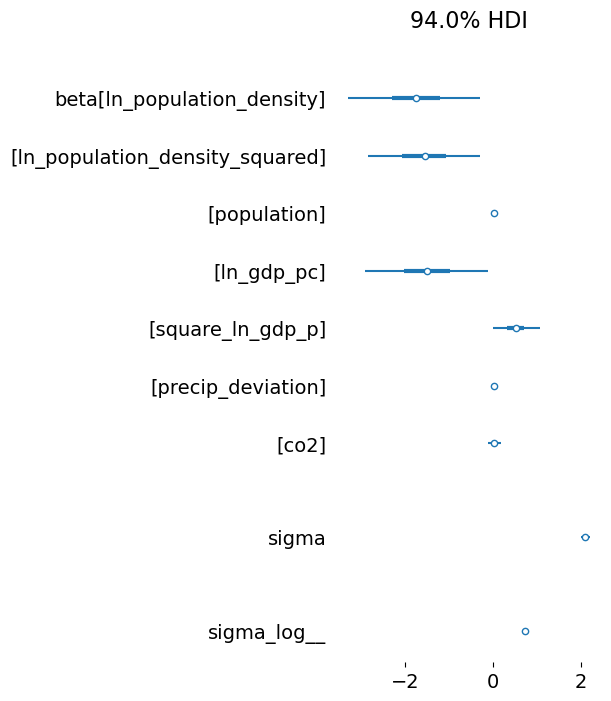

In [22]:
az.plot_forest(simple_damages_idata, var_names = ["~country_effect", "~country_effect_offset"], combined = True);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


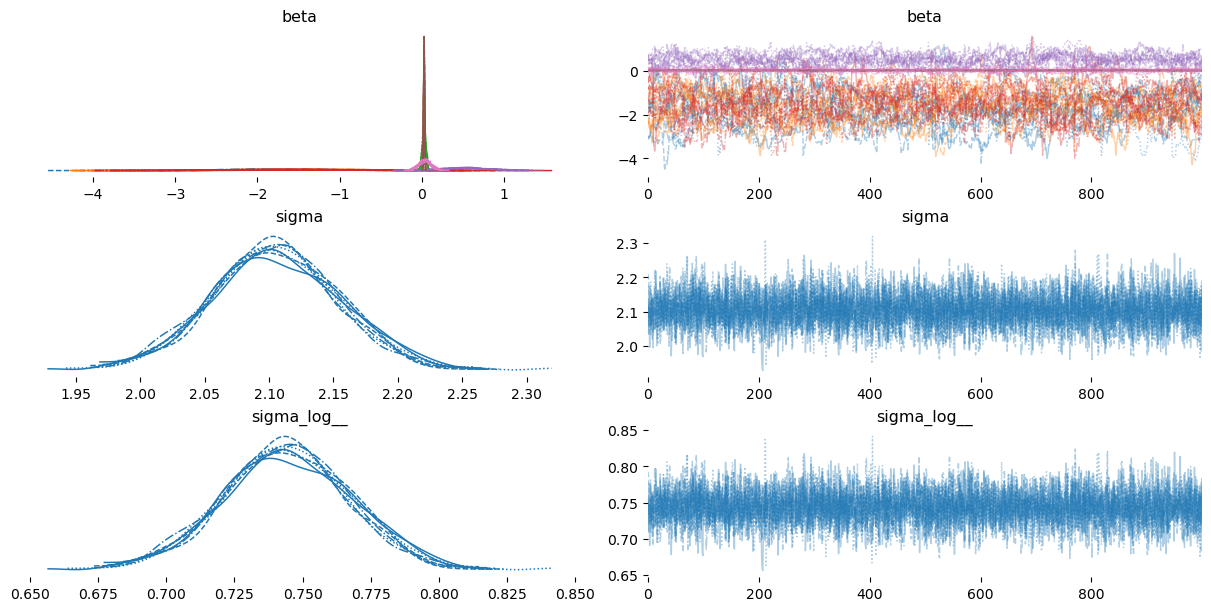

In [23]:
az.plot_trace(simple_damages_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

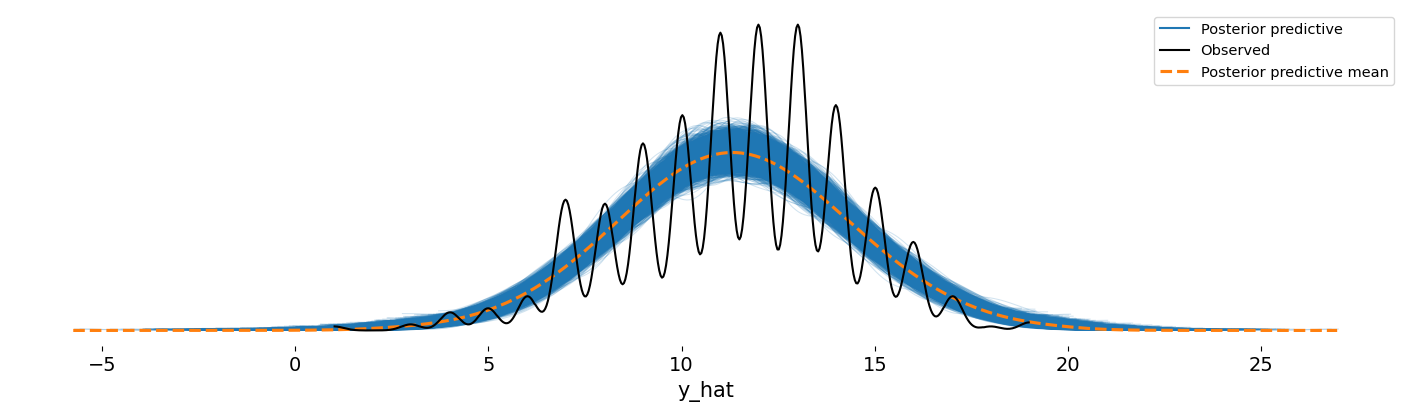

In [24]:
az.plot_ppc(simple_damages_idata);

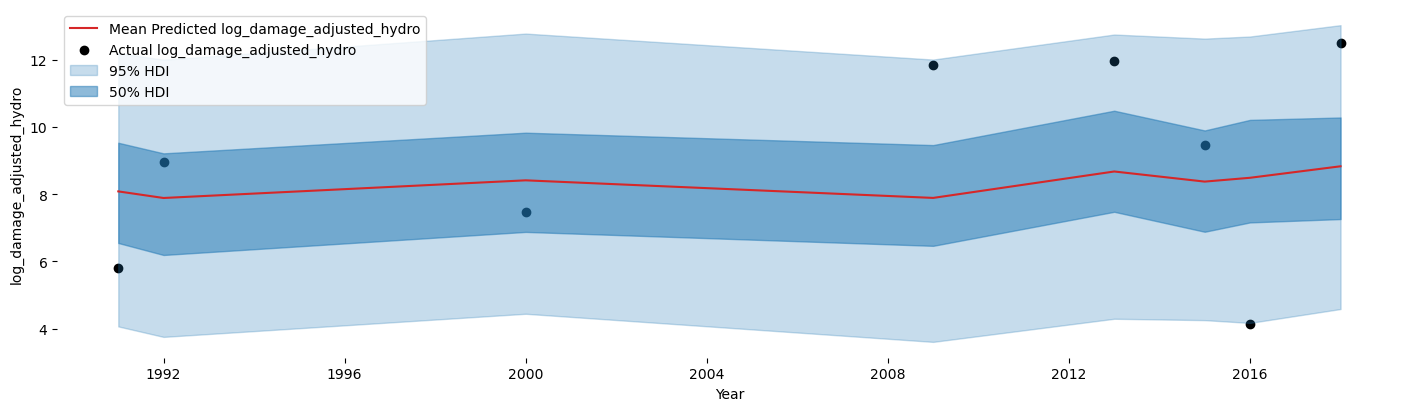

In [25]:
plotting_function(idata =simple_damages_idata , 
                  country = "LAO",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

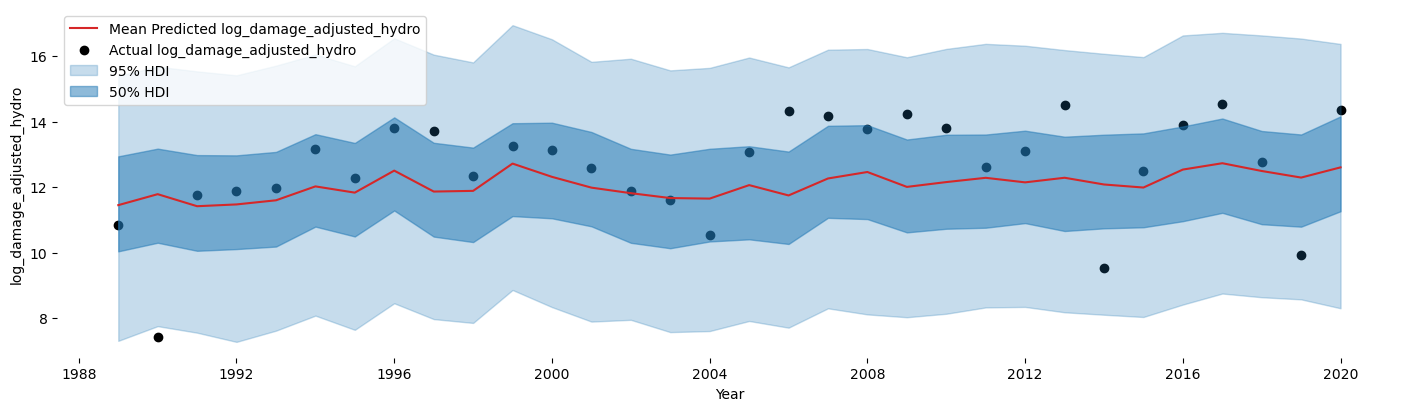

In [26]:
plotting_function(idata =simple_damages_idata , 
                  country = "VNM",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

# Damage predictions

# Disaster predictions